# pyLLS-notebook
* This notebook introduces a tutorial for pyLLS.
* pyLLS is a missing value imputation algorithm based on Local Least Square imputation (LLSimpute).
* In this tutorial, we will use CCLE gene expression data to estimate expression values of artificial missing genes in TCGA.

## Parameters and library setting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
from copy import deepcopy as dc
import warnings
import matplotlib.pyplot as plt
import os
import time
import random
from tqdm import tqdm
from sklearn.impute import KNNImputer
# Modify path where pyLLS.py is located.
# If you already installed pyLLS, ignore it.
#sys.path.append('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS')

import pyLLS
print(pyLLS.__version__)

0.5


In [2]:
params={
    'ccle-exp':'/home/sjoh/workdir/00_db/ccle/22Q2/ccle-entrez-max.pickle'
    ,'tcga-exp':'/home/sjoh/workdir/00_db/tcga/00_pancancer/d220927_1105v01_TCGA-PANCANCER-RSEM-RNAseqv2.pickle'
}

## Data Loading

In [3]:
indata={}

In [4]:
import pickle
def load_pickle(path):
    '''
    This function loads pickle data
    '''
    with open(path,'rb') as f:
        data1=pickle.load(f)
        f.close()
    return data1
    

indata['ccle-exp']=load_pickle(params['ccle-exp'])
indata['tcga-exp']=load_pickle(params['tcga-exp'])

## pyLLS benchmark
* We are going to compare performance of linear regression models with features selected by L1-norm, L2-norm, and PCC.<br>
They are evaluated by normalized root mean squared error (NRMSE):<br>
<img src="https://i.imgur.com/bPJlC17.jpg" width="600px" height="150px" title="Fig1.Variant_difference" /></a>

* From 10 to 1000 genes will be randomly selected to measure performance of them.
* CCLE data will be used as reference and TCGA data will be used target data.
* Genes that are not expressed in both data will be excluded. As they are mere constant.

In [5]:
pdata={}

### Preprocessing

In [7]:
# TCGA-data preprocessing
import random
random.seed(1234) # fix seed number for reproducible result
def preprocess_TCGAdata(x=indata['tcga-exp']):
    '''
    TCGA data has "Hybridization REF" column.
    The column contains gene symbol and entrez id which are distinguished by "|" separator.
    This function returns a matrix containing genes with entrez-ids with average expression values greater than zero.
    As tumor samples are sorted according to their tissue of origin, NRMSE value may be fluctuated by addition of different tissue.
    Therefore, samples were shuffled to prevent the fluctuation.
    '''
    warnings.simplefilter('ignore')
    # Select 10,000 samples randomly
    random_sample=random.sample(x.columns.tolist()[1:],1000)
    # Remove genes that are not expressed in the selected samples.
    x1=x.loc[:,['Hybridization REF']+random_sample]
    x1[['symbol','entrez']]=x1['Hybridization REF'].str.split('|').tolist()
    x1.index=x1['entrez'].tolist()
    x1=x1.drop(['symbol','Hybridization REF','entrez'],axis=1)
    x1=x1.astype(float)
    # Log2-scaling
    x1=np.log2(x1+1)
    mean_gene=x1.mean(axis=1).round(decimals=3)
    std_gene=x1.std(axis=1).round(decimals=3)
    x1=x1.loc[(mean_gene>0) & (std_gene>0),:].round(3) # keep genes that are expressed in cell lines
    warnings.resetwarnings()
    return x1


if os.path.exists('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/tcga-exp-benchmark.csv')==False:
    pdata['tcga-exp']=preprocess_TCGAdata(x=indata['tcga-exp'])
    pdata['tcga-exp'].to_csv('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/tcga-exp-benchmark.csv')
else:
    pdata['tcga-exp']=pd.read_csv('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/tcga-exp-benchmark.csv',index_col=0)
    pdata['tcga-exp'].index=[str(i) for i in pdata['tcga-exp'].index]


pdata['tcga-exp']

,TCGA-VS-A8EH-01A-11R-A36F-07,TCGA-L5-A88W-01A-11R-A354-31_x,TCGA-A3-3363-01A-01R-0864-07,TCGA-RC-A7SB-01A-21R-A352-07,TCGA-75-7025-01A-12R-1949-07,TCGA-CJ-6030-11A-01R-1672-07,TCGA-ED-A459-01A-11R-A266-07,TCGA-24-1435-01A-01R-1566-13,TCGA-BH-A1FN-01A-11R-A13Q-07,TCGA-QQ-A5VA-01A-12R-A32Q-07,...,TCGA-G9-6363-01A-21R-1789-07,TCGA-DB-A4XC-01A-11R-A26U-07,TCGA-E9-A5UO-01A-11R-A28M-07,TCGA-32-4213-01A-01R-1850-01,TCGA-BR-A4J7-01A-31R-A251-31_y,TCGA-IQ-A61I-01A-11R-A30B-07,TCGA-LB-A7SX-01A-11R-A33R-07,TCGA-RD-A8NB-01A-12R-A39E-31_x,TCGA-A2-A3XZ-01A-42R-A239-07,TCGA-AA-3502-01A-01R-1410-07
100130426,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
100133144,4.153,3.656,3.247,2.523,5.453,1.019,0.000,3.956,4.200,4.561,...,3.020,3.615,4.016,2.137,5.505,1.459,4.262,4.366,2.425,3.599
100134869,4.281,4.567,2.806,3.565,4.417,2.455,3.492,4.850,2.582,4.085,...,2.377,3.595,4.919,3.349,4.589,0.000,2.794,3.508,4.399,3.539
10357,6.067,4.839,6.600,6.426,6.325,5.794,5.930,4.626,6.706,6.311,...,7.243,7.812,6.255,5.642,3.535,6.897,5.894,3.685,7.376,7.725
10431,9.011,9.822,10.353,10.807,9.377,10.010,10.005,10.359,10.303,9.164,...,10.914,9.179,9.828,9.443,9.424,10.351,10.042,9.551,9.914,9.252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7791,10.765,13.542,12.441,12.370,11.924,10.556,12.652,13.355,11.467,11.874,...,10.682,10.734,11.510,12.498,13.503,10.960,12.364,12.889,12.806,10.839
23140,9.992,11.076,9.573,8.589,10.513,10.143,9.208,9.349,9.944,10.717,...,9.140,11.103,9.726,9.268,10.678,10.117,9.995,11.513,10.064,10.032
26009,9.719,9.473,10.137,8.888,8.958,9.723,9.447,9.768,10.677,9.195,...,10.032,9.648,9.634,8.967,9.456,8.299,9.616,9.918,9.880,9.659
387590,1.575,1.332,2.334,1.764,9.142,7.703,2.615,3.693,4.689,4.970,...,8.393,10.661,2.611,4.547,7.806,2.021,4.754,4.726,5.091,3.277


In [8]:
# CCLE data preprocessing
def preprocess_CCLEdata(x=indata['ccle-exp']):
    '''
    This function is similar to preprocess_TCGAdata().
    It removes genes that are not expressed across all samples in CCLE data.
    '''
    x.index=x['entrez'].astype(str).tolist()
    x1=x.drop('entrez',axis=1)
    x1=np.log2(x1+1)
    mean_gene=x1.iloc[:,:].mean(axis=1).round(decimals=3)
    std_gene=x1.iloc[:,:].std(axis=1).round(decimals=3)
    x1=x1.loc[(mean_gene>0) & (std_gene>0),:] # Genes with 0 std will be removed
    return x1


if os.path.exists('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/ccle-exp-benchmark.csv')==False:
    pdata['ccle-exp']=preprocess_CCLEdata(x=indata['ccle-exp'])
else:
    pdata['ccle-exp']=pd.read_csv('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/ccle-exp-benchmark.csv',index_col=0)
    pdata['ccle-exp'].index=[str(i) for i in pdata['ccle-exp'].index]
    

pdata['ccle-exp']

,22RV1_PROSTATE,2313287_STOMACH,253JBV_URINARY_TRACT,253J_URINARY_TRACT,42MGBA_CENTRAL_NERVOUS_SYSTEM,5637_URINARY_TRACT,59M_OVARY,639V_URINARY_TRACT,647V_URINARY_TRACT,697_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,...,WSUDLCL2_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,YAPC_PANCREAS,YD10B_UPPER_AERODIGESTIVE_TRACT,YD15_SALIVARY_GLAND,YD38_UPPER_AERODIGESTIVE_TRACT,YD8_UPPER_AERODIGESTIVE_TRACT,YH13_CENTRAL_NERVOUS_SYSTEM,YKG1_CENTRAL_NERVOUS_SYSTEM,ZR751_BREAST,ZR7530_BREAST
1,0.344916,0.018005,0.118699,0.306389,2.187090,0.023434,1.873187,1.858482,0.151632,2.473454,...,3.034520,0.024520,0.022205,0.137780,0.035996,0.234709,1.480100,1.453233,2.482100,2.076966
2,1.570249,0.007564,0.103132,0.062850,0.047628,0.048158,0.239151,0.027420,0.078553,0.164212,...,0.180779,0.147462,0.115933,0.092765,0.131156,1.002796,1.006585,0.316628,0.124455,0.619515
9,3.479761,2.588433,0.635575,0.806071,1.187837,1.077920,0.486597,1.091971,1.443776,1.482895,...,1.985169,1.614851,0.948379,1.190419,1.359943,1.146961,1.118140,1.153663,4.561833,2.026322
10,0.000000,0.239607,0.017559,0.017464,0.117308,0.058555,0.032131,0.016792,0.181834,0.007907,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.012764,0.000000,0.000000,1.118041,0.158829
12,0.016938,1.760596,0.220744,0.362863,0.010212,0.401269,0.046913,0.004949,0.004938,0.048060,...,0.592533,1.685272,0.392170,0.517325,0.635921,0.899954,0.926878,0.057327,1.896551,0.315927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118568804,0.013880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
119139905,0.148171,0.113340,0.503523,0.717728,0.244921,0.034722,0.056213,0.254324,0.425944,0.208050,...,0.043171,0.000000,0.000000,0.885831,0.135734,0.416273,0.000000,0.708639,0.300847,0.064369
120356739,3.169016,1.530810,1.266948,1.112280,1.049958,1.147189,0.908110,1.186646,1.047280,1.335838,...,1.301974,2.023940,1.766133,1.904222,1.345402,1.251677,1.013255,1.272555,2.920894,2.410100
122455339,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016085,...,0.037515,0.000000,0.000000,0.000000,0.040569,0.000000,0.000000,0.000000,0.000000,0.000000


In [9]:
# Export TCGA-exp and CCLE-exp to conduct 
path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/'
if os.path.exists(f'{path}/ccle-exp-benchmark.csv')==0:
    pdata['ccle-exp'].to_csv(f'{path}/ccle-exp-benchmark.csv')
    pdata['tcga-exp'].to_csv(f'{path}/tcga-exp-benchmark.csv')

In [10]:
if os.path.exists(f'{path}/ccle-exp-benchmark.csv'):
    pdata['ccle-exp']=pd.read_csv(f'{path}/ccle-exp-benchmark.csv',index_col=0)
    pdata['tcga-exp']=pd.read_csv(f'{path}/tcga-exp-benchmark.csv',index_col=0)

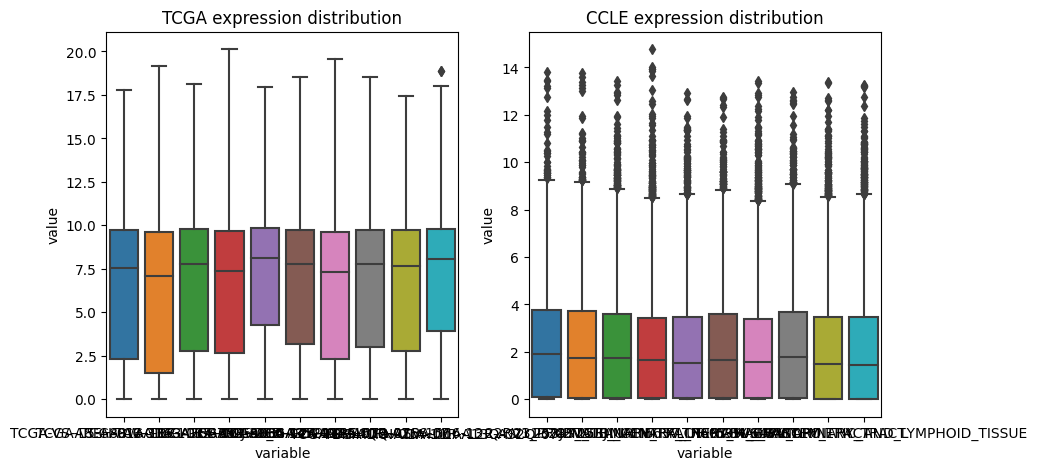

In [11]:
# Compare distribution
plt.figure(figsize=(10,5))
# TCGA
plt.subplot2grid((1,2),loc=[0,0])
sns.boxplot(data=pdata['tcga-exp'].iloc[:,:10].melt(),x='variable',y='value')
plt.title('TCGA expression distribution')
plt.subplot2grid((1,2),loc=[0,1])
sns.boxplot(data=pdata['ccle-exp'].iloc[:,:10].melt(),x='variable',y='value')
plt.title('CCLE expression distribution')
plt.show()
# As you can see, distribution between CCLE and TCGA is quite different.
# These boxplots indicates that TCGA and CCLE transcriptome data were generated from different sequencing platform and pipeline.

### Benchmark

#### Scenario1 : Imputate missing value in an independent dataset with different numbers of missing entries.
* pyLLS-PCC, pyLLS-L1norm, pyLLS-L2norm, and rLLS-PCC  will be compared.
* The number of missing genes incrased by 100 from 10 to 300 by 50.
* Missing genes are randomly selected and they will used in all methods identically.
* K is fixed to 10.
* Imputation will be repated 3 times.
* In case of R-LLSimpute, please run 'R-llsimpute_benchmark.r'.<br> This will produce time and NRMSE values for the R-LLSimpute.

In [12]:
# Select missing genes
# To compare NRMSE between pyLLS and rLLS, missing genes should be identical.
# Therefore, we will randomly select missing genes to conduct benchmark
def select_missing_genes_randomly(
    x=pdata['ccle-exp'],y=pdata['tcga-exp'],
    minM=10,maxM=300,by=50,times=5):
    # prepare missing number range
    iteration,n_of_missing_genes,computation_time=[],[],[]
    missing_num=[i for i in range(0,maxM+1,by)]
    missing_num[0]=minM
    # Prepare data
    overlap_gene=list(set(x.index)&set(y.index))
    missing_gene_list=[]
    for i in range(times):
        for num in missing_num:
            missing_gene_list.append([str(gene) for gene in random.sample(overlap_gene,num)])
    missing_gene_list=[','.join(genes) for genes in missing_gene_list]
    return missing_gene_list

pdata['missing-gene-entry']=select_missing_genes_randomly(
    x=pdata['ccle-exp'],y=pdata['tcga-exp'],minM=10,maxM=100,by=50,times=3)

path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/'
with open(f'{path}/missing-gene-list.txt','w',encoding='utf8') as f:
    for k in pdata['missing-gene-entry']:
        f.write(k+'\n')
    f.close()

In [13]:
pdata['missing-gene-entry'][0]

'871,1719,51684,28998,55765,151306,221749,5551,57121,3663'

In [14]:
path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/'
with open(f'{path}/missing-gene-list.txt','r') as f:
    pdata['missing-gene-entry']=f.readlines()
    f.close()    

    
pdata['missing-gene-entry']=[i.split()[0].split(',') for i in pdata['missing-gene-entry']]

In [15]:
# Computation time
def computation_time_for_pyLLS_with_fixedK(
    x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'],
    n_jobs=1,k=10,metric='correlation'
    ):
    '''
    This function conducts imputation with ccle-exp and tcga-exp.
    ccle-exp and tcga-exp will be used as reference and target.
    minM and maxM = The number of missing genes
    k = The number of probe genes to be evaluated.
    '''
    # prepare missing number range
    computation_time=[]
    # Prepare data
    overlap_gene=[str(i) for i in set(x.index)&set(y.index)]
    print(len(overlap_gene))
    x.index=list(x.index.astype(str))
    y.index=list(y.index.astype(str))
    x1=x.loc[overlap_gene,:]
    y1=y.loc[overlap_gene,:]
    overlap_gene=set(overlap_gene)
    # Save result
    nrmse_list,iteration_list,missing_num_list,time_list=[],[],[],[]
    warnings.simplefilter('ignore')
    for miss in tqdm(missing_entry):
        y2=y1.loc[list(overlap_gene-set(miss)),:] # Make missing gene table
        # Pearson correlation
        start=time.time() # Start time
        y3=pyLLS.impute_missing_gene(ref=x1,target=y2,maxK=k,useKneedle=False,verbose=False,metric=metric,n_jobs=n_jobs)
        end=time.time() # End time
        # Calculate NRMSE (normalized root mean squar error)
        answer=np.round(y1.loc[miss,:].values,5)
        pred=np.round(y3.loc[miss,:].values,5)
        nrmse=(((answer-pred)**2).mean()**(1/2))/answer.std()
        # store result
        time_list.append(end-start)
        nrmse_list.append(nrmse)
        missing_num_list.append(len(miss))
    df=pd.DataFrame([])
    df['iteration']=iteration_list
    df['missing_num']=missing_num_list
    df['nrmse']=nrmse_list
    df['time']=time_list
    #warnings.resetwarnings()
    return df

# This is a time consuming process.
# This process may take 60 minutes or more depending on your computer environment.
path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/'
if 'pyLLS-cor' not in list(pdata):
    for core_num in [1,4]:
        tmp={}
        tmp[f'pyLLS-cor-c{core_num}']=computation_time_for_pyLLS_with_fixedK(x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'],metric='correlation',n_jobs=core_num)
        tmp[f'pyLLS-L1-c{core_num}']=computation_time_for_pyLLS_with_fixedK(x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'],metric='l1',n_jobs=core_num)
        tmp[f'pyLLS-L2-c{core_num}']=computation_time_for_pyLLS_with_fixedK(x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'],metric='l2',n_jobs=core_num)
        with open(f'{path}/01-pyLLS-CCLE-TCGA-benchmark-core{core_num}.pickle','wb') as f:
            pickle.dump(tmp,f)
            f.close()

18148


  0%|                                                                                                                                    | 0/9 [00:00<?, ?it/s]

18148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:28<00:00,  3.20s/it]


18148


  0%|                                                                                                                                    | 0/9 [00:00<?, ?it/s]

18148


  0%|                                                                                                                                    | 0/9 [00:00<?, ?it/s]

18148


  0%|                                                                                                                                    | 0/9 [00:00<?, ?it/s]

18148


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:04<00:00,  1.93it/s]


In [16]:
# you should run R-llsimpute-benchmark.r
# path in the script should be optimized to your local environment.
pdata['rLLS-cor']=pd.read_csv('/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/R-llsimpute-test-result.csv')

for core in [1,4]:
    tmp=load_pickle(f'/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/01-pyLLS-CCLE-TCGA-benchmark-core{core}.pickle')
    pdata[f'pyLLS-cor-c{core}']=tmp[f'pyLLS-cor-c{core}']
    pdata[f'pyLLS-L1-c{core}']=tmp[f'pyLLS-L1-c{core}']
    pdata[f'pyLLS-L2-c{core}']=tmp[f'pyLLS-L2-c{core}']

In [24]:
# Scikit-learn-KNNimpute (sklearn-KNN)
def computation_time_for_KNN_with_fixedK(
    x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry']
    ):
    '''
    it is similar to computation_time_for_pyLLS_with_fixedK() function
    '''
    knn_imputer=KNNImputer()
    # prepare missing number range
    computation_time=[]
    # Prepare data
    overlap_gene=set(x.index)&set(y.index)
    x1=x.loc[list(overlap_gene),:]
    y1=y.loc[list(overlap_gene),:]
    x1.index=list(x1.index.astype(str))
    y1.index=list(y1.index.astype(str))
    # Save result
    nrmse_list,iteration_list,missing_num_list,time_list=[],[],[],[]
    warnings.simplefilter('ignore')
    for miss in tqdm(missing_entry):
        y2=y1.copy().T
        y2.loc[:,miss]=np.nan # Make missing gene table
        # Pearson correlation
        start=time.time() # Start time
        knn_imputer.fit(x1.values.T)
        y4=knn_imputer.transform(y2.values) # sample x gene table.
        end=time.time() # End time
        y4=pd.DataFrame(y4)
        y4.columns=y2.columns
        y4.index=y2.index
        # Calculate NRMSE (normalized root mean squar error)
        answer=np.round(y1.loc[miss,y2.index.tolist()].values.T,5)
        pred=np.round(y4.loc[y2.index.tolist(),miss].values,5)
        nrmse=(((answer-pred)**2).mean()**(1/2))/answer.std()
        # store result
        time_list.append(end-start)
        nrmse_list.append(nrmse)
        missing_num_list.append(len(miss))
    df=pd.DataFrame([])
    df['iteration']=iteration_list
    df['missing_num']=missing_num_list
    df['nrmse']=nrmse_list
    df['time']=time_list
    #warnings.resetwarnings()
    return df

pdata['KNN-impute']=computation_time_for_KNN_with_fixedK(x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [03:20<00:00, 22.23s/it]


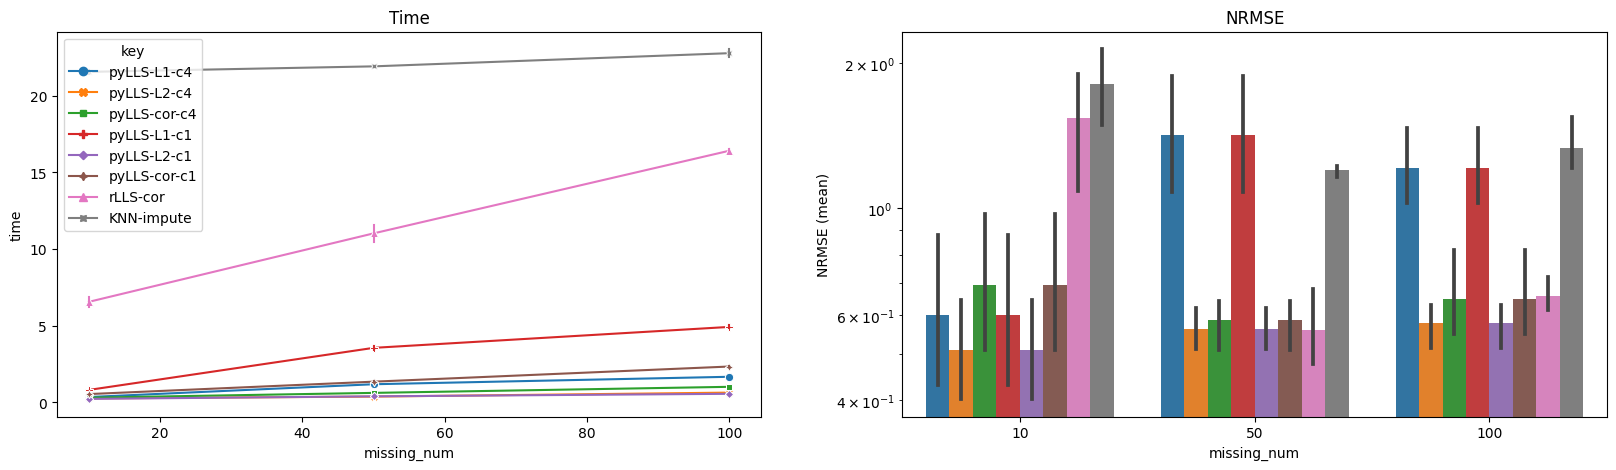

In [25]:
def compare_performance(x=pdata,keys=['pyLLS-L1-c4','pyLLS-L2-c4','pyLLS-cor-c4','rLLS-cor','KNN-impute']):
    '''
    This function plots computation time and NRMSE values for pyLLS and R-LLS.
    x = pdata containing pyLLS result
    keys = ['pyLLS-L1','pyLLS-L2','pyLLS-cor'], key-names that have time and NRMSE values.
    '''
    # Merging table
    df=pd.DataFrame([])
    key_col=[]
    for key in keys:
        k1=x[key]
        key_col+=[key]*k1.shape[0]
        df=pd.concat([df,k1])
    df['key']=key_col
    df=df.reset_index(drop=1)
    df['nrmse']=df['nrmse'].round(5)
    # Plotting
    plt.figure(figsize=(20,5))
    plt.subplot2grid((1,2),loc=[0,0])
    sns.lineplot(data=df,x='missing_num',y='time',hue='key',ci='sd',err_style='bars',markers=True,dashes=False,style='key')
    plt.title('Time')
    plt.subplot2grid((1,2),loc=[0,1])
    sns.barplot(data=df,x='missing_num',y='nrmse',hue='key')
    plt.legend([],[], frameon=False)
    plt.ylabel('NRMSE (mean)')
    plt.title('NRMSE')
    plt.yscale('log')
    plt.show()
    return df.drop('iteration',axis=1)

pdata['benchmark-CCLEtoTCGA']=compare_performance(x=pdata,keys=['pyLLS-L1-c4','pyLLS-L2-c4','pyLLS-cor-c4',
'pyLLS-L1-c1','pyLLS-L2-c1','pyLLS-cor-c1','rLLS-cor','KNN-impute'])
# Fixed K = 10, TCGA (n=1,000), and CCLE (n=1,019)
# Pearson correlation shows the best performance for missing value estimation in terms of both computation time and NRMSE.
# pyLLS is much faster than rLLS while their error values are insignificantly different.

key,KNN-impute,pyLLS-L1-c1,pyLLS-L1-c4,pyLLS-L2-c1,pyLLS-L2-c4,pyLLS-cor-c1,pyLLS-cor-c4,rLLS-cor
missing_num,,,,,,,,
10,92.156904,3.496165,1.516732,1.000000,1.130152,2.337251,1.334595,28.056085
50,57.158932,9.286399,3.099288,1.042883,1.000000,3.536368,1.629116,28.755989
100,40.365427,8.731224,2.968486,1.000000,1.138903,4.153826,1.808508,29.093439


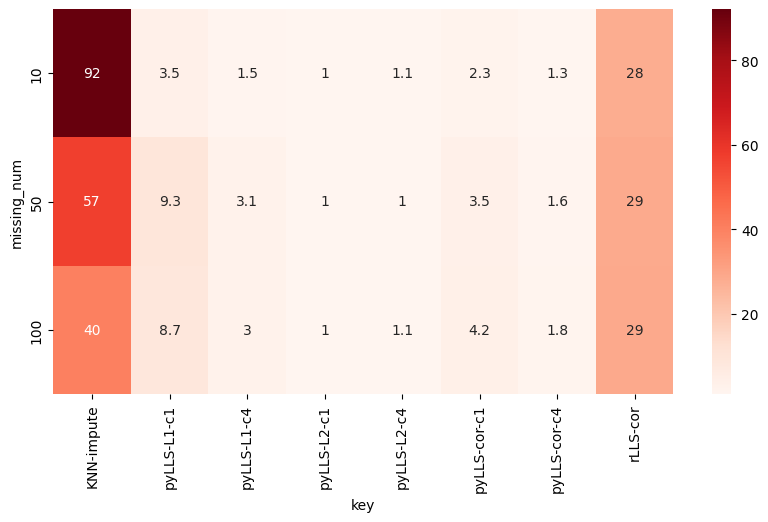

In [26]:
# Check execution time
def how_fast(x=pdata['benchmark-CCLEtoTCGA']):
    '''
    This function calculates time-ratio how pyLLS is fast compared to rLLS
    '''
    x1=x.groupby(['missing_num','key']).mean()
    missing_num=x['missing_num'].unique()
    for n in missing_num:
        base=x1.loc[n,'time'].min()
        x1.loc[n,'time']=x1.loc[n,'time'].values/base
    x2=x1.sort_values('time').reset_index().pivot(index='missing_num',columns='key',values='time')
    plt.figure(figsize=(10,5))
    sns.heatmap(x2.round(2),cmap='Reds',annot=True)
    return x2
how_fast(x=pdata['benchmark-CCLEtoTCGA'])

#### Scenario2 : Imputate different sample sizes.
* In this scenario, the number of samples in TCGA data will ranges from 10 to 1,000.
* The number of missing genes is set to 10.
* Missing genes are randomly selected and they will used in all methods identically.
* K is fixed to 10.
* Imputation will be repated 3 times.
* In case of R-LLSimpute, please run 'R-llsimpute_benchmark.r'.<br> This will produce time and NRMSE values for the R-LLSimpute.

In [28]:
# Computation time
def time_for_pyLLS_with_different_sample_sizes(
    x=pdata['ccle-exp'],y=pdata['tcga-exp'],missing_entry=pdata['missing-gene-entry'],
    n_jobs=1,k=10,metric='correlation',min_sample=10,max_sample=1000,by=500,missing_gene_num=10
    ):
    '''
    This function conducts imputation with ccle-exp and tcga-exp.
    ccle-exp and tcga-exp will be used as reference and target.
    min_sample and max_sample = The number of samples.
    k = The number of probe genes to be evaluated.
    missing_gene_num=100
    '''
    # Select missing genes
    missing_entries=[i for i in missing_entry if len(i)==missing_gene_num]
    # prepare missing number range
    sample_sizes=[i for i in range(0,max_sample,by)]
    sample_sizes[0]=min_sample
    sample_sizes.append(max_sample)
    computation_time=[]
    # Prepare data
    x.index=x.index.astype(str).tolist()
    y.index=y.index.astype(str).tolist()
    overlap_gene=set(x.index)&set(y.index)
    x1=x.loc[list(overlap_gene),:]
    y1=y.loc[list(overlap_gene),:]
    x1.index=list(x1.index.astype(str))
    y1.index=list(y1.index.astype(str))
    # target samples # missing
    missing_samples=list(y1.columns)
    # Save result
    nrmse_list,missing_num_list,time_list,missing_sample_size_list=[],[],[],[]
    warnings.simplefilter('ignore')
    for miss in tqdm(missing_entries):
        for ref_size in sample_sizes:
            y2=y1.loc[list(overlap_gene-set(miss)),missing_samples[:ref_size]] # Make missing gene table
            # Pearson correlation
            start=time.time() # Start time
            y3=pyLLS.impute_missing_gene(ref=x1,target=y2,maxK=k,useKneedle=False,verbose=False,metric=metric,n_jobs=n_jobs)
            end=time.time() # End time
            # Calculate NRMSE (normalized root mean squar error)
            answer=np.round(y1.loc[miss,missing_samples[:ref_size]].values,5)
            pred=np.round(y3.loc[miss,missing_samples[:ref_size]].values,5)
            nrmse=(((answer-pred)**2).mean()**(1/2))/answer.std()
            # store result
            time_list.append(end-start)
            nrmse_list.append(nrmse)
            missing_num_list.append(len(miss))
            missing_sample_size_list.append(ref_size)
    df=pd.DataFrame([])
    df['missing_sample_size']=missing_sample_size_list
    df['nrmse']=nrmse_list
    df['time']=time_list
    df['missing_gene_num']=missing_gene_num
    warnings.resetwarnings()
    return df

path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/'
if 'pyLLS-cor-c1-diff-sample-size' not in list(pdata) or 1:
    for core_num in [1,4]:
        tmp={}
        tmp[f'pyLLS-cor-c{core_num}-diff-sample-size']=time_for_pyLLS_with_different_sample_sizes(metric='correlation',n_jobs=core_num,missing_gene_num=10)
        tmp[f'pyLLS-L1-c{core_num}-diff-sample-size']=time_for_pyLLS_with_different_sample_sizes(metric='l1',n_jobs=core_num,missing_gene_num=10)
        tmp[f'pyLLS-L2-c{core_num}-diff-sample-size']=time_for_pyLLS_with_different_sample_sizes(metric='l2',n_jobs=core_num,missing_gene_num=10)
        with open(f'{path}/01-pyLLS-CCLE-TCGA-benchmark-c{core_num}-diff-sample-sizes.pickle','wb') as f:
            pickle.dump(tmp,f)
            f.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.02it/s]


18148
18148
18148
18148
18148
18148


In [29]:
path='/home/sjoh/workdir/00_tools/LLSimpute/pyLLS/benchmark/'
for core_num in [1,4]:
    tmp=load_pickle(f'{path}/01-pyLLS-CCLE-TCGA-benchmark-c{core_num}-diff-sample-sizes.pickle')
    pdata[f'pyLLS-cor-c{core_num}-diff-sample-size']=tmp[f'pyLLS-cor-c{core_num}-diff-sample-size']
    pdata[f'pyLLS-L1-c{core_num}-diff-sample-size']=tmp[f'pyLLS-L1-c{core_num}-diff-sample-size']
    pdata[f'pyLLS-L2-c{core_num}-diff-sample-size']=tmp[f'pyLLS-L2-c{core_num}-diff-sample-size']
    del tmp

pdata['rLLS-cor-diff-sample-size']=pd.read_csv(path+'/R-llsimpute-test-result-diff-sizes.csv')

In [30]:
pdata['rLLS-cor-diff-sample-size']

,missing_gene_num,nrmse,time,missing_sample_size
0,10,0.978829,2.892094,10
1,10,0.970243,4.301590,500
2,10,0.975810,5.765674,1000
3,10,0.461133,2.918889,10
4,10,0.502079,4.506079,500
5,10,0.509222,6.572989,1000
6,10,0.595617,3.084808,10
7,10,0.599163,3.960774,500
8,10,0.592294,5.163344,1000


/tmp/ipykernel_732999/3515678215.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df,x='missing_sample_size',y='time',hue='key',ci='sd',err_style='bars',markers=True,dashes=False,style='key')


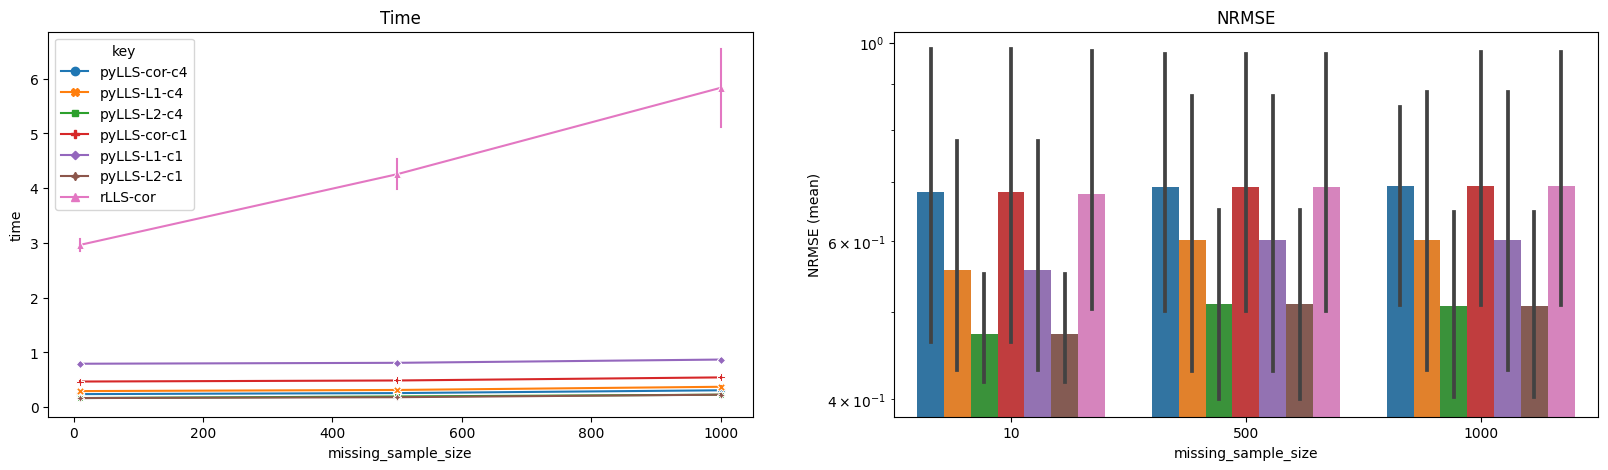

In [31]:
keys=[f'pyLLS-{v}-c4-diff-sample-size' for v in ['cor','L1','L2'] ]
keys+=[f'pyLLS-{v}-c1-diff-sample-size' for v in ['cor','L1','L2'] ]
keys+=['rLLS-cor-diff-sample-size']
def compare_performance_with_diffSamplesize(x=pdata,keys=keys):
    # Merging table
    df=pd.DataFrame([])
    key_col=[]
    for key in keys:
        k1=x[key]
        key_col+=[key]*k1.shape[0]
        df=pd.concat([df,k1])
    df['key']=key_col
    df['key']=df['key'].apply(lambda x: x.replace('-diff-sample-size',''))
    df=df.reset_index(drop=1)
    df['nrmse']=df['nrmse'].round(5)
    # Plotting
    plt.figure(figsize=(20,5))
    plt.subplot2grid((1,2),loc=[0,0])
    sns.lineplot(data=df,x='missing_sample_size',y='time',hue='key',ci='sd',err_style='bars',markers=True,dashes=False,style='key')
    plt.title('Time')
    plt.subplot2grid((1,2),loc=[0,1])
    sns.barplot(data=df,x='missing_sample_size',y='nrmse',hue='key')
    plt.legend([],[], frameon=False)
    plt.ylabel('NRMSE (mean)')
    plt.title('NRMSE')
    plt.yscale('log')
    plt.show()

compare_performance_with_diffSamplesize(x=pdata,keys=keys)